In [0]:
from google.colab import drive
drive.mount("/content/drive")
!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'   colored-mnist.pkl   pixel_cnn.ipynb


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time

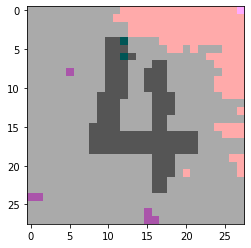

In [0]:
train, val, test = None, None, None

# load data
with open('/content/drive/My Drive/colored-mnist.pkl', 'rb') as f:
    data = pickle.load(f)
    train, val= np.split(data["train"],[50000])
    test = data["test"]
    
# show images
def show_img(sample):
    _, axs = plt.subplots(10, 10, figsize=(28, 28))
    axs = axs.flatten()
    for img, ax in zip(sample, axs):
        ax.imshow((img / 3 * 255).astype(int))
    plt.show()

# show training img
plt.imshow(train[1232] / 3)
plt.show()

In [0]:
# masked conv layer for pixelcnn
class MaskedConv2d(nn.Conv2d):
    
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, stride, padding):
        super(MaskedConv2d, self).__init__(in_channels, 
                                           out_channels, 
                                           kernel_size=kernel_size, 
                                           stride=stride,
                                           padding=padding)
        
        self.register_buffer('mask', self.weight.data.clone())
        _, _, H, W = self.weight.size()
        
        # mask example (3x3)
        # 1  1  1 
        # 1 1=B 0
        # 0  0  0
        
        self.mask.fill_(0)
        if mask_type == 'A':
            self.mask[:,:,0:H//2,:] = 1
            self.mask[:,:, H//2, 0:W//2] = 1
        elif mask_type == 'B':
            self.mask[:,:,0:H//2,:] = 1
            self.mask[:,:, H//2, 0:W//2 + 1] = 1
        else:
            pass
        
        #print("mask",self.mask[0][0])
            
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)
        
# res block for pixelcnn # paper
class PixelCNN_ResidualBlock(nn.Module):
    
    def __init__(self, features):
        super().__init__()
        
        self.conv1 = MaskedConv2d('B', features, features//2,
                                  kernel_size=1,stride=1, padding=0)
        self.batch1 = nn.BatchNorm2d(features//2)

        self.conv2 = MaskedConv2d('B', features//2, features//2,
                                  kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(features//2)

        self.conv3 = MaskedConv2d('B', features//2, features,
                                  kernel_size=1,stride=1, padding=0)
        self.batch3 = nn.BatchNorm2d(features)
        
    def forward(self, x):
        identity = x
        out = F.relu(self.batch1(self.conv1(x)))
        out = F.relu(self.batch2(self.conv2(out)))
        out = F.relu(self.batch3(self.conv3(out)))
        out = identity + out
        return out
    


In [0]:
# https://arxiv.org/abs/1601.06759
class PixelCNN(nn.Module):

    def __init__(self, in_channels, colors_per_channel):
        super().__init__()
        self.colors_per_channel = colors_per_channel
        
        # conv mask A
        self.conv_A1 = MaskedConv2d('A' , in_channels, 128, kernel_size=7, stride=1, padding=3)
        self.batch_A1 = nn.BatchNorm2d(128)
        
        # multiple(12) residual blocks 
        self.r1 = PixelCNN_ResidualBlock(128)
        self.r2 = PixelCNN_ResidualBlock(128)
        self.r3 = PixelCNN_ResidualBlock(128)
        self.r4 = PixelCNN_ResidualBlock(128)
        self.r5 = PixelCNN_ResidualBlock(128)
        self.r6 = PixelCNN_ResidualBlock(128)
        self.r7 = PixelCNN_ResidualBlock(128)
        self.r8 = PixelCNN_ResidualBlock(128)
        self.r9 = PixelCNN_ResidualBlock(128)
        self.r10 = PixelCNN_ResidualBlock(128)
        self.r11 = PixelCNN_ResidualBlock(128)
        self.r12 = PixelCNN_ResidualBlock(128)
        
        # (ReLu) followed by 1x1 conv, mask B(2 layers)
        self.conv_B1 = MaskedConv2d('B' , 128, 128, kernel_size=1, stride=1, padding=0)
        self.batch_B1 = nn.BatchNorm2d(128)

        self.conv_B2 = MaskedConv2d('B' , 128, 128, kernel_size=1, stride=1, padding=0)
        self.batch_B2 = nn.BatchNorm2d(128)
        
        # channels
        self.conv_channels = nn.Conv2d(128, colors_per_channel * 3, kernel_size=1, stride=1, padding=0)
        self.batch_channels = nn.BatchNorm2d(128)
        
    def forward(self, x):
        batch_size = x.size()[0]
        
        # conv mask A
        out = F.relu(self.batch_A1(self.conv_A1(x)))
        
        # multiple(12) residual blocks 
        out = self.r1(out)
        out = self.r2(out)
        out = self.r3(out)
        out = self.r4(out)
        out = self.r5(out)
        out = self.r6(out)
        out = self.r7(out)
        out = self.r8(out)
        out = self.r9(out)
        out = self.r10(out)
        out = self.r11(out)
        out = self.r12(out)
        
        # (ReLu) followed by 1x1 conv, mask B(2 layers)
        out = F.relu(self.batch_B1(self.conv_B1(out)))
        out = F.relu(self.batch_B2(self.conv_B2(out)))

        channels = F.relu(self.conv_channels(out))
        channels = channels.view(batch_size, 3, self.colors_per_channel,28,28)
        channels = channels.permute(0,1,3,4,2)
        return channels

In [0]:
#setup
batch_size = 96
train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val, batch_size=batch_size)

pixelcnn = PixelCNN(3,4)
pixelcnn.cuda()
optimizer = optim.Adam(pixelcnn.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

training_loss = []
val_loss = []

#training
for epoch in range(40):
    
    print(f"**** EPOCH {epoch} ****")
    start_time = time.time()


    pixelcnn.train(True)
    training_loss_tmp = []
    for i, y in enumerate(train_dl):
        
        y = y.permute(0,3,1,2).type('torch.FloatTensor').cuda()
        
        out = pixelcnn(y)
        out = out.contiguous()
        out = out.view(-1, 4)
        target = y.data.view(-1).long()
        
        
        loss = loss_fn(out, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss_tmp.append(loss.cpu().detach().numpy())
    
    # val loss
    val_tmp = []
    for i, y in enumerate(val_dl):
    
        y = y.permute(0,3,1,2).type('torch.FloatTensor').cuda()

        out = pixelcnn(y)
        out = out.contiguous()
        out = out.view(-1, 4)
        target = y.data.view(-1).long()


        loss = loss_fn(out, target)
        val_tmp.append(loss.cpu().detach().numpy())
    
    # mean train & val loss
    training_loss.append(np.mean(np.array(training_loss_tmp)))
    val_loss.append(np.mean(np.array(val_tmp)))
    
    print(f'Train loss: {np.mean(np.array(training_loss_tmp))} | Val loss: {np.mean(np.array(val_tmp))}')
          
    # time
    end_time = time.time()
    print(f'time elapsed: {end_time - start_time} \n******************')
    

**** EPOCH 0 ****
Train loss: 0.21764793992042542 | Val loss: 0.1299503594636917
time elapsed: 71.4178364276886 
******************
**** EPOCH 1 ****
Train loss: 0.11184091120958328 | Val loss: 0.10708881914615631
time elapsed: 71.40516114234924 
******************
**** EPOCH 2 ****
Train loss: 0.10219178348779678 | Val loss: 0.10165956616401672
time elapsed: 71.38737630844116 
******************
**** EPOCH 3 ****
Train loss: 0.0986948013305664 | Val loss: 0.09883672744035721
time elapsed: 71.35522127151489 
******************
**** EPOCH 4 ****
Train loss: 0.09658601135015488 | Val loss: 0.09770616143941879
time elapsed: 71.35809469223022 
******************
**** EPOCH 5 ****
Train loss: 0.09517868608236313 | Val loss: 0.09607473760843277
time elapsed: 71.31042861938477 
******************
**** EPOCH 6 ****
Train loss: 0.09393714368343353 | Val loss: 0.0955352783203125
time elapsed: 71.30607032775879 
******************
**** EPOCH 7 ****
Train loss: 0.0929202288389206 | Val loss: 0.094

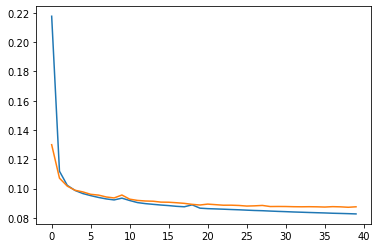

In [0]:
plt.plot(range(len(training_loss)), training_loss)
plt.plot(range(len(val_loss)), val_loss)

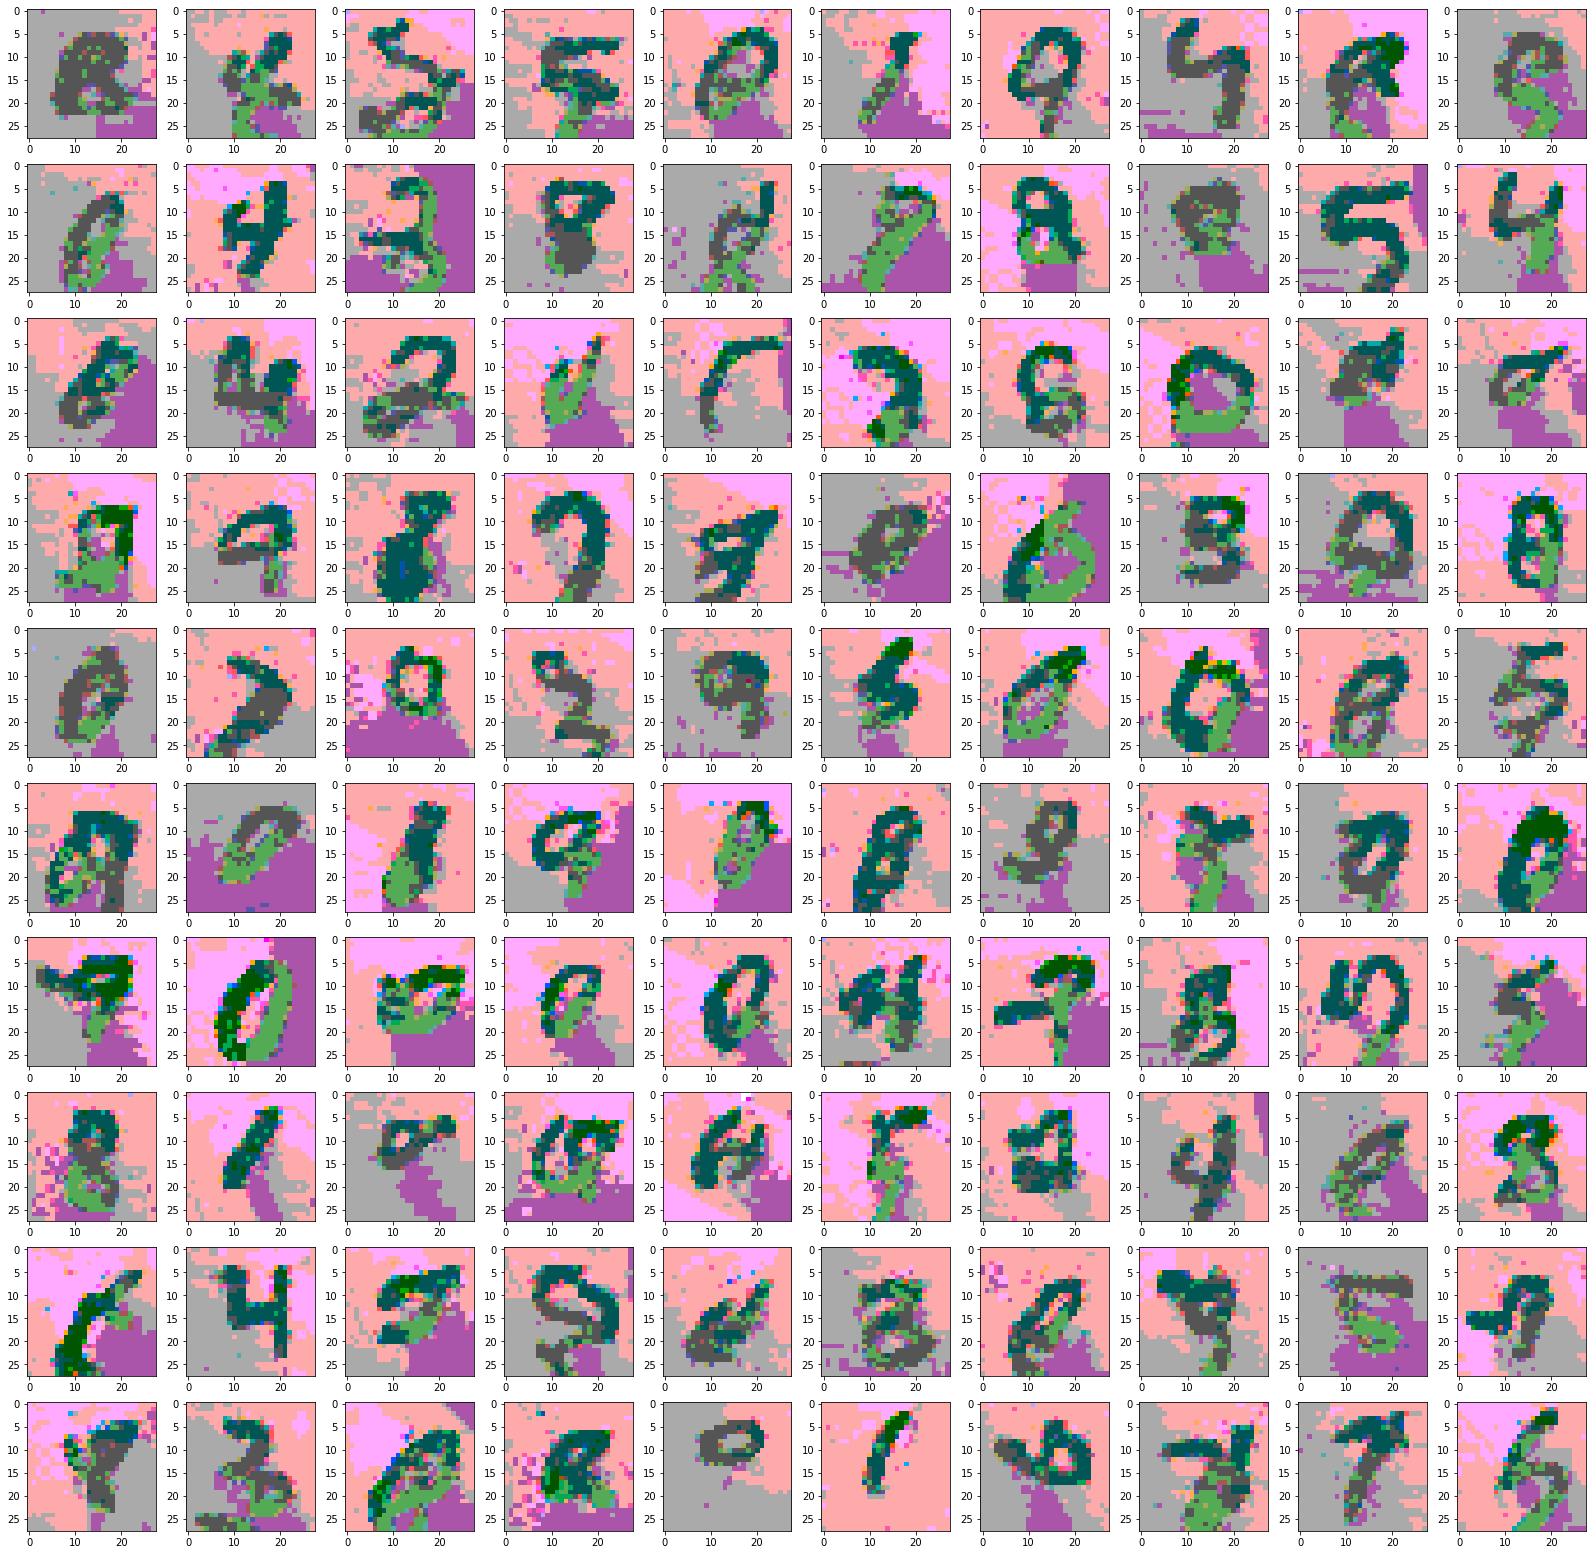

In [0]:
# sample 100 images
sample = torch.zeros(100, 3, 28, 28).cuda()
pixelcnn.train(False)
for i in range(28):
    for j in range(28):
        
        out = pixelcnn(sample)
        out = F.softmax(out, dim=4)
        probs = out[:, :, i, j]
        for k in range(3):
            pixel = torch.multinomial(probs[:, k], 1)
            sample[:, k, i, j] = pixel[:,0]
            
sample = sample.permute(0,2,3,1).cpu().detach().numpy()
show_img(sample)

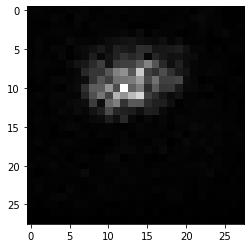

In [0]:
# show receptive field of the pixelcnn

loss_fn = nn.CrossEntropyLoss()
rnd_img = Variable(torch.round((torch.rand(1,3,28,28)*3)),requires_grad=True)
pixelCNN = PixelCNN(3,4)


out = pixelCNN(rnd_img)
pixel_distr = out[0,:,14,14]
target = torch.tensor([1,2,3])

loss = loss_fn(pixel_distr,target)
loss.backward()

receptive_field = rnd_img.grad.data[0].permute(1,2,0).detach().numpy()
receptive_field = np.abs(receptive_field).max(axis=2)
plt.imshow(receptive_field,cmap='gray')